# Two-dimensional quantum dot in a harmonic oscillator potential subject to a laser field.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tdhf import HartreeFock
from quantum_systems import TwoDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccd import OATDCCD
from coupled_cluster.integrators import GaussIntegrator

In [2]:
class LaserPulse:

    def __init__(self, t_0=0, t_final=5, omega=8, strength=0.03):
        self.t_0 = t_0
        self.t_final = t_final
        self.omega = omega
        self.strength = strength

    def __call__(self, t):
        if not self.t_0 < t < self.t_final:
            return 0

        return self.strength * np.sin(self.omega * t)

In [3]:
n = 2
l = 12

radius = 4
num_grid_points = 401
omega = 1
mass = 1

tdho = TwoDimensionalHarmonicOscillator(n, l, radius, num_grid_points, omega=omega, mass=mass)
tdho.setup_system()

hf = HartreeFock(tdho, verbose=True)
C = hf.scf(tolerance=1e-12)
tdho.change_basis(C)

HF converged to given precision in 9 iterations
Ehf: (3.1626913498656277+0j)


In [4]:
laser = LaserField(LaserPulse())

polarization_vector = np.zeros(2)
polarization_vector[0] = 1

tdho.set_time_evolution_operator(laser)
tdho.set_polarization_vector(polarization_vector)

In [5]:
cc_kwargs = dict(verbose=True)
theta_t = 0.1
theta_l = 0.1
tol = 1e-4

integrator = GaussIntegrator(np=np, eps=1e-10)
oatdccd = OATDCCD(tdho, np=np, integrator=integrator, **cc_kwargs)

t_kwargs = dict(theta=theta_t, tol=tol)
l_kwargs = dict(theta=theta_l, tol=tol)

oatdccd.compute_ground_state(t_kwargs=t_kwargs, l_kwargs=l_kwargs)
print("Ground state CCD energy: {0}".format(oatdccd.compute_ground_state_energy()))

Iteration: 0	Diff (t): [100]
Iteration: 1	Diff (t): [0.019389056210272107]
Iteration: 2	Diff (t): [0.006828719119863963]
Iteration: 3	Diff (t): [0.002582508747376311]
Iteration: 4	Diff (t): [0.001002421373664214]
Iteration: 5	Diff (t): [0.0003922587342228834]
Iteration: 6	Diff (t): [0.00015385648079990766]
Iteration: 7	Diff (t): [6.038623543824784e-05]
Iteration: 0	Diff (l): [100]
Iteration: 1	Diff (l): [0.014515335115458772]
Iteration: 2	Diff (l): [0.005470096502442567]
Iteration: 3	Diff (l): [0.002124698602952224]
Iteration: 4	Diff (l): [0.0008324648837589876]
Iteration: 5	Diff (l): [0.0003268942773610173]
Iteration: 6	Diff (l): [0.00012842040925381548]
Iteration: 7	Diff (l): [5.044760231964762e-05]
Ground state CCD energy: (3.039066883283313+0j)


/home/schoyen/anaconda3/envs/cc/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


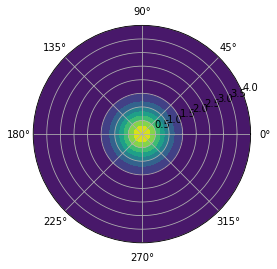

In [6]:
rho = oatdccd.compute_ground_state_particle_density()

plt.subplot(1, 1, 1, polar=True)
plt.contourf(tdho.T, tdho.R, rho)
plt.show()

In [7]:
oatdccd.set_initial_conditions()

In [8]:
num_timesteps = 1001
t_end = 10
time_points = np.linspace(0, t_end, num_timesteps)

In [9]:
psi_overlap = np.zeros(num_timesteps, dtype=np.complex128)
td_energies = np.zeros(num_timesteps, dtype=np.complex128)

psi_overlap[0] = oatdccd.compute_time_dependent_overlap()
td_energies[0] = oatdccd.compute_energy()

In [10]:
for i, amp in enumerate(oatdccd.solve(time_points)):
    print(100 * " ", end="\r")
    print(f"i = {i} / {num_timesteps}", end="\r")
    psi_overlap[i + 1] = oatdccd.compute_time_dependent_overlap()
    td_energies[i + 1] = oatdccd.compute_energy()

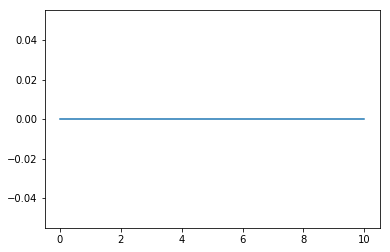

In [11]:
plt.plot(time_points, psi_overlap.real)
plt.show()

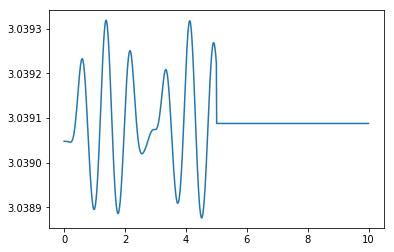

In [12]:
plt.plot(time_points, td_energies.real)
plt.show()